In [397]:
import pandas as pd
import numpy as np

In [398]:
df = pd.read_csv('reality_df.csv')

In [399]:
df.head()

,_id,title,address,description,price,updated,size,area,owner,building_type,...,loggia,umistneni_objektu,doprava,voda,odpad,obcanska_vybavenost,id,garage,available_from,date_updated
0,https://www.prazskereality.cz/prostorny-hezky-...,"Byt na prodej, 2+1, Praha 3 - Žižkov","Praha 3 - Žižkov, Čajkovského",Byt na prodej / 2+1 / 77 m2 - Byty na prodej t...,7700000,23.04.2021,2+1,77.0,osobní,cihlová,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26
1,https://www.prazskereality.cz/exkluzivne-nabiz...,"Byt na prodej, 4+kk, Praha 1 - Nové Město","Praha 1 - Nové Město, Soukenická",Byt na prodej / 4+kk / 151 m2 - Byty na prodej...,19500000,23.04.2021,4+kk,151.0,osobní,cihlová,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26
2,https://www.prazskereality.cz/nabizim-k-prodej...,"Byt na prodej, 3+1, Praha 5 - Hlubočepy","Praha 5 - Hlubočepy, 15 200, Lamačova 824/9",Byt na prodej / 3+1 / 74 m2 - Byty na prodej t...,6950000,23.04.2021,3+1,74.0,osobní,panelová,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26
3,https://www.prazskereality.cz/prodej-luxusniho...,"Byt na prodej, 5+1, Praha 5 - Smíchov","Praha 5 - Smíchov, 15 000, Holečkova 3331/35",Byt na prodej / 5+1 / 277 m2 - Byty na prodej ...,29900000,23.04.2021,5+1,277.0,osobní,skeletová,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26
4,https://www.prazskereality.cz/v-soucasne-situa...,"Byt na prodej, 3+kk, Praha 2 - Vinohrady","Praha 2 - Vinohrady, 12 000, U Zvonařky 2536/1a",Byt na prodej / 3+kk / 71 m2 - Byty na prodej ...,12500000,23.04.2021,3+kk,71.0,osobní,skeletová,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26


In [400]:
len(df)

4350

In [401]:
df.describe()

,area,id
count,4344.000000,426.000000
mean,20.060313,640773.375587
std,40.049383,43456.763128
min,0.000000,167870.000000
25%,3.000000,648419.500000
50%,6.000000,654581.500000
75%,9.000000,657890.500000
max,969.000000,660611.000000


In [402]:
list(df.isna().sum()[df.isna().sum() > 500].index)

['updated',
 'state',
 'equipment',
 'barrier_free',
 'city_part',
 'city',
 'street',
 'building_state',
 'floor_max',
 'heating',
 'locality',
 'electricity',
 'parking',
 'gas',
 'internet',
 'annual_electricity',
 'loggia',
 'umistneni_objektu',
 'doprava',
 'voda',
 'odpad',
 'obcanska_vybavenost',
 'id',
 'garage',
 'available_from']

In [403]:
cols_to_drop = list(df.isna().sum()[df.isna().sum() > 500].index)

In [404]:
cols_to_drop

['updated',
 'state',
 'equipment',
 'barrier_free',
 'city_part',
 'city',
 'street',
 'building_state',
 'floor_max',
 'heating',
 'locality',
 'electricity',
 'parking',
 'gas',
 'internet',
 'annual_electricity',
 'loggia',
 'umistneni_objektu',
 'doprava',
 'voda',
 'odpad',
 'obcanska_vybavenost',
 'id',
 'garage',
 'available_from']

In [405]:
df = df.drop(columns = cols_to_drop)
df = df.drop(columns = ['address', 'description', 'date_updated', 'title'])

In [406]:
df.set_index('_id', inplace = True)

In [407]:
df.head()

,price,size,area,owner,building_type,balcony,basement,elevator,floor,penb,terrace
_id,,,,,,,,,,,
https://www.prazskereality.cz/prostorny-hezky-svetly-byt-2-1-v-ov-umisteny-ve-2-np-cin-7386380.html,7700000,2+1,77.0,osobní,cihlová,False,True,True,2,G,False
https://www.prazskereality.cz/exkluzivne-nabizime-klimatizovany-byt-4-kk-umisteny-v-5--6726946.html,19500000,4+kk,151.0,osobní,cihlová,False,True,True,6,G,False
https://www.prazskereality.cz/nabizim-k-prodeji-velmi-pekny-zrekonstruovany-vybaveny-b-7358790.html,6950000,3+1,74.0,osobní,panelová,False,True,True,3,NaN,False
https://www.prazskereality.cz/prodej-luxusniho-mezonetoveho-bytu-5-1-s-moznosti-odpoct-7384977.html,29900000,5+1,277.0,osobní,skeletová,False,True,True,2,NaN,True
https://www.prazskereality.cz/v-soucasne-situaci-nabizime-bezne-prohlidky-s-rouskou-a--7358850.html,12500000,3+kk,71.0,osobní,skeletová,False,False,True,3,NaN,False


In [408]:
df['penb'].fillna('G', inplace = True)

In [409]:
df.building_type.value_counts()

cihlová             2251
smíšená              691
panelová             417
Cihla                260
skeletová            251
Cihlová              184
Panel                112
Panelová              54
Ostatní               40
Smíšená               39
Skeletová             14
Nízkoenergetický      14
kamenná                3
montovaná              2
dřevěná                1
Kamenná                1
Montovaná              1
Name: building_type, dtype: int64

In [410]:
df['building_type'] = df['building_type'].replace('Cihla', 'cihlová')
df['building_type'] = df['building_type'].replace('Cihlová', 'cihlová')
df['building_type'] = df['building_type'].replace('Panel', 'panelová')
df['building_type'] = df['building_type'].replace('Panelová', 'panelová')
df['building_type'] = df['building_type'].replace('Smíšená', 'smíšená')
df['building_type'] = df['building_type'].replace('Skeletová', 'skeletová')
df['building_type'] = df['building_type'].replace('Kamenná', 'kamenná')
df['building_type'] = df['building_type'].replace('Montovaná', 'montovaná')

In [411]:
df.building_type.value_counts()

cihlová             2695
smíšená              730
panelová             583
skeletová            265
Ostatní               40
Nízkoenergetický      14
kamenná                4
montovaná              3
dřevěná                1
Name: building_type, dtype: int64

In [412]:
#df['rooms'] = df['size'].apply(lambda x: str(x)[:1])

In [413]:
def get_number_of_rooms(row):
    if 'Garsoniéra' in str(row):
        n_rooms = 1
    elif 'Ostatní' in str(row):
        n_rooms = np.nan
    else:
        n_rooms = str(row)[:1]
    return n_rooms

In [414]:
df.dropna(subset = ['size'], inplace = True)

In [415]:
df['rooms'] = df['size'].apply(get_number_of_rooms)

In [416]:
df['kitchen'] = df['size'].apply(lambda x: False if 'kk' in str(x) else True)

In [417]:
df[['kitchen', 'rooms', 'size']].head()

,kitchen,rooms,size
_id,,,
https://www.prazskereality.cz/prostorny-hezky-svetly-byt-2-1-v-ov-umisteny-ve-2-np-cin-7386380.html,True,2,2+1
https://www.prazskereality.cz/exkluzivne-nabizime-klimatizovany-byt-4-kk-umisteny-v-5--6726946.html,False,4,4+kk
https://www.prazskereality.cz/nabizim-k-prodeji-velmi-pekny-zrekonstruovany-vybaveny-b-7358790.html,True,3,3+1
https://www.prazskereality.cz/prodej-luxusniho-mezonetoveho-bytu-5-1-s-moznosti-odpoct-7384977.html,True,5,5+1
https://www.prazskereality.cz/v-soucasne-situaci-nabizime-bezne-prohlidky-s-rouskou-a--7358850.html,False,3,3+kk


In [418]:
df.owner.value_counts()

osobní        3345
Osobní         387
družstevní     219
Družstevní      38
s.r.o.          16
jiný            16
Ostatní          1
Name: owner, dtype: int64

In [419]:
df['owner'] = df['owner'].replace('Osobní', 'osobní')
df['owner'] = df['owner'].replace('Družstevní', 'družstevní')
df['owner'] = df['owner'].replace('Ostatní', 'jiný')

In [420]:
df.drop('size', inplace = True, axis = 1)

In [421]:
for column in ['basement', 'terrace', 'balcony', 'elevator']:
    df[column].fillna(False, inplace = True)

In [422]:
df.head()

,price,area,owner,building_type,balcony,basement,elevator,floor,penb,terrace,rooms,kitchen
_id,,,,,,,,,,,,
https://www.prazskereality.cz/prostorny-hezky-svetly-byt-2-1-v-ov-umisteny-ve-2-np-cin-7386380.html,7700000,77.0,osobní,cihlová,False,True,True,2,G,False,2,True
https://www.prazskereality.cz/exkluzivne-nabizime-klimatizovany-byt-4-kk-umisteny-v-5--6726946.html,19500000,151.0,osobní,cihlová,False,True,True,6,G,False,4,False
https://www.prazskereality.cz/nabizim-k-prodeji-velmi-pekny-zrekonstruovany-vybaveny-b-7358790.html,6950000,74.0,osobní,panelová,False,True,True,3,G,False,3,True
https://www.prazskereality.cz/prodej-luxusniho-mezonetoveho-bytu-5-1-s-moznosti-odpoct-7384977.html,29900000,277.0,osobní,skeletová,False,True,True,2,G,True,5,True
https://www.prazskereality.cz/v-soucasne-situaci-nabizime-bezne-prohlidky-s-rouskou-a--7358850.html,12500000,71.0,osobní,skeletová,False,False,True,3,G,False,3,False


In [423]:
df['penb'].value_counts()

G                            1263
B                             730
B (vyhl. č. 78/2013 Sb.)      557
G (vyhl. č. 78/2013 Sb.)      477
C                             414
D                             226
C (vyhl. č. 78/2013 Sb.)      148
G (vyhl. č. 148/2007 Sb.)     126
E                             104
D (vyhl. č. 78/2013 Sb.)       73
C (vyhl. č. 148/2007 Sb.)      51
B (vyhl. č. 148/2007 Sb.)      34
E (vyhl. č. 78/2013 Sb.)       22
F                              21
A                              20
A (vyhl. č. 78/2013 Sb.)       14
D (vyhl. č. 148/2007 Sb.)      13
F (vyhl. č. 78/2013 Sb.)        8
E (vyhl. č. 148/2007 Sb.)       5
F (vyhl. č. 148/2007 Sb.)       5
Name: penb, dtype: int64

In [424]:
df['penb'] = df['penb'].apply(lambda x: str(x)[:1])

In [425]:
df.penb.value_counts()

G    1866
B    1321
C     613
D     312
E     131
F      34
A      34
Name: penb, dtype: int64

In [426]:
df['floor'].value_counts()

1. patro (2. NP)                                 649
2. patro (3. NP)                                 602
3. patro (4. NP)                                 459
4. patro (5. NP)                                 415
přízemí (1. NP = nadzemní podlaží)               307
5. patro (6. NP)                                 292
6. patro (7. NP)                                 177
2                                                108
2.0                                               90
3                                                 88
1                                                 88
1.0                                               87
7. patro (8. NP)                                  85
4                                                 77
3.0                                               60
6                                                 59
4.0                                               51
5                                                 47
8. patro (9. NP)                              

In [427]:
def get_floor_number(row):
    import re
    floor = re.search(r'([-\d]+)', str(row))
    if floor is not None:
        floor = floor[0]
    return floor    

In [428]:
df['floor'] = df['floor'].apply(get_floor_number)

In [429]:
df.rooms

_id
https://www.prazskereality.cz/prostorny-hezky-svetly-byt-2-1-v-ov-umisteny-ve-2-np-cin-7386380.html    2
https://www.prazskereality.cz/exkluzivne-nabizime-klimatizovany-byt-4-kk-umisteny-v-5--6726946.html    4
https://www.prazskereality.cz/nabizim-k-prodeji-velmi-pekny-zrekonstruovany-vybaveny-b-7358790.html    3
https://www.prazskereality.cz/prodej-luxusniho-mezonetoveho-bytu-5-1-s-moznosti-odpoct-7384977.html    5
https://www.prazskereality.cz/v-soucasne-situaci-nabizime-bezne-prohlidky-s-rouskou-a--7358850.html    3
                                                                                                      ..
https://www.bezrealitky.cz/nemovitosti-byty-domy/554869-nabidka-prodej-bytu                            3
https://www.bezrealitky.cz/nemovitosti-byty-domy/647801-nabidka-prodej-bytu-vinohradska-praha          2
https://www.bezrealitky.cz/nemovitosti-byty-domy/460989-nabidka-prodej-bytu-olbrachtova-praha-4        2
https://www.bezrealitky.cz/nemovitosti-byty-domy/46

In [430]:
df_checkpoint = df.copy()

In [431]:
df['rooms'].value_counts()

2    1516
3    1343
1     825
4     473
5     120
6      22
1       6
7       4
Name: rooms, dtype: int64

In [432]:
df[df.area.isna()]

,price,area,owner,building_type,balcony,basement,elevator,floor,penb,terrace,rooms,kitchen
_id,,,,,,,,,,,,
https://reality.idnes.cz/detail/prodej/byt/praha-20-k-berance/6059f8dcb50f835ad5172a43/?s-et=flat&s-ot=sale&s-l=VUSC-19,9490000,NaN,osobní,cihlová,True,True,False,1,G,False,3,False
https://reality.idnes.cz/detail/prodej/byt/praha-8-sokolovska/6052651ac6965d1062537502/?s-et=flat&s-ot=sale&s-l=VUSC-19,8990000,NaN,družstevní,cihlová,False,True,False,5,G,False,3,True
https://reality.idnes.cz/detail/prodej/byt/praha-15-v-osikach/605a148d9f52e15f1a135582/?s-et=flat&s-ot=sale&s-l=VUSC-19,6980000,NaN,osobní,cihlová,False,False,False,1,G,False,2,False
https://reality.idnes.cz/detail/prodej/byt/praha-3-zelenky-hajskeho/5ff62af8e542f56cc23942f2/?s-et=flat&s-ot=sale&s-l=VUSC-19,8490000,NaN,osobní,cihlová,True,True,True,2,G,False,2,False
https://reality.idnes.cz/detail/prodej/byt/praha-5-plzenska/5ffeb097df1dab36b56b2052/?s-et=flat&s-ot=sale&s-l=VUSC-19,4580800,NaN,osobní,NaN,False,True,True,None,G,False,2,False
https://reality.idnes.cz/detail/prodej/byt/praha-3-jeseniova/5fbaa7fc73d5e019803c83b2/?s-et=flat&s-ot=sale&s-l=VUSC-19,7490000,NaN,osobní,cihlová,False,True,False,2,E,False,3,True


In [433]:
df.dropna(subset = ['owner', 'building_type'], inplace = True)

In [434]:
df.isna().sum()

price              0
area               5
owner              0
building_type      0
balcony            0
basement           0
elevator           0
floor            157
penb               0
terrace            0
rooms              2
kitchen            0
dtype: int64

In [435]:
from sklearn.model_selection import train_test_split

y = df.pop('price')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [436]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_cols = ['area', 'rooms', 'floor']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_cols = ['owner', 'building_type', 'penb']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [437]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state = 42, n_estimators = 250)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', forest)])


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.467


In [468]:
from sklearn.metrics import mean_squared_error

In [469]:
mean_squared_error(y_pred, y_test)

20894615854084.766

In [470]:
mean_squared_error(y_pred, y_test, squared = False)

4571062.880128074

In [467]:
X_train.columns

Index(['area', 'owner', 'building_type', 'balcony', 'basement', 'elevator',
       'floor', 'penb', 'terrace', 'rooms', 'kitchen'],
      dtype='object')

In [441]:
y_pred = clf.predict(X_test)

In [453]:
results = pd.DataFrame(data = {'predicted': y_pred, 'actual': y_test})
results['actual'] = results['actual'].astype(float)

In [454]:
results

,predicted,actual
_id,,
https://reality.idnes.cz/detail/prodej/byt/praha-8-sokolovska/6061edb32710000a19746093/?s-et=flat&s-ot=sale&s-l=VUSC-19,2.316814e+07,14680000.0
https://reality.idnes.cz/detail/prodej/byt/praha-5-podbelohorska/60702d5318ca410971155703/?s-et=flat&s-ot=sale&s-l=VUSC-19,1.090403e+07,14137742.0
https://reality.idnes.cz/detail/prodej/byt/praha-5-ke-smichovu/5e15d5e737ba4d5b094f8943/?s-et=flat&s-ot=sale&s-l=VUSC-19,1.292157e+07,9400000.0
https://reality.idnes.cz/detail/prodej/byt/praha-8-brezenska/6076f0844317a32fda5eccc3/?s-et=flat&s-ot=sale&s-l=VUSC-19,8.910746e+06,11778300.0
https://reality.idnes.cz/detail/prodej/byt/praha-3-basilejske-namesti/6032871896241e63d2616613/?s-et=flat&s-ot=sale&s-l=VUSC-19,8.185484e+06,6500000.0
...,...,...
https://reality.idnes.cz/detail/prodej/byt/praha-9-pod-harfou/602153b40f9f27434d43b4ab/?s-et=flat&s-ot=sale&s-l=VUSC-19,1.314413e+07,12891755.0
https://reality.idnes.cz/detail/prodej/byt/praha-3-kristanova/5f1fd8e037ba4d0c9b244123/?s-et=flat&s-ot=sale&s-l=VUSC-19,6.020869e+06,6300000.0
https://www.bezrealitky.cz/nemovitosti-byty-domy/653246-nabidka-prodej-bytu-herlikovicka-hlavni-mesto-praha,1.315837e+07,8890000.0


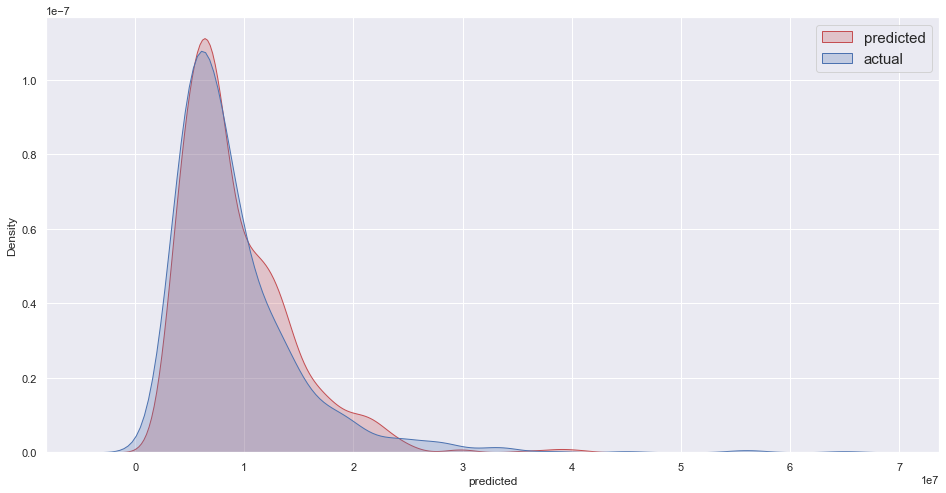

In [466]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
figsize = (16,8)

fig, axs = plt.subplots(figsize=figsize)
# plotting bo'th distibutions on the same figure
fig = sns.kdeplot(results['predicted'], shade=True, color="r")
fig = sns.kdeplot(results['actual'], shade=True, color="b")
plt.legend(['predicted', 'actual'], fontsize = 15)
plt.show()